# Confidence bands and envelopes

Confidence intervals is a good way to visualise uncertainty of a particular paramater.
However, we are sometimes interested in the uncertainty many parameters or in the uncertainty of a function:

* how a predictor $f:[0,1]\to\mathbb{R}$ depends on the training set
* how a ROC curve $\mathrm{Roc}:[0,1]\to[0,1]$ depends on the test set
* where a quantile-quantile plot $\mathrm{qq}:[0,1]\to[0,1]$ should lie if the null hypotesis is satisfied

To adress this issue, we can compute confidence intervals for individual inputs and then draw the corresponding envelope. Such an envelope is called a **pointwise confidence band**. 
Alternatively, we might be able to find an envelope where the function is expected to be in $95\%$ fraction of cases. 
Such an envelope is called **simultaneous confidence band**.
For obvious reasons, simultaneous confidence bands are much wider than pointwise bands.  

Confidence envelopes can be devised also for visualising uncertainty of several parameters at once. For instance, showing the uncertainty of mean and variance estimtors at the same figure. 

In the following, we explain how to compute pointwise confidece intervals for the examples listed above.

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame

from tqdm import tnrange
from plotnine import *

from scipy.interpolate import interp1d
from scipy import stats

## I. What is a quantile-quantile plot?

We can compare data sources by comparing samples taken form them. 
For instance, we can compute the mean value and variance for both samples and compare them.
This gives a nice overview but discards a lot of information about the exact shapes of the distributions.

Quantile-quantile plots are the best way to compare samples from two different distributions. In brief, if `x` and `y` are sample vectors of same size coming from two different distributions then
then plotting `x.sort()` against `y.sort()` produces qq-plot.

By sorting the values, we compute the quantiles of the distribution. Hence, the plot visualises how the corresponding quantiles are related. If `x` and `y` come from the same distribution, the resulting graph should ideally follow the line $x = y$. Due to random fluctuations, the plot deviates from a straight line. 
In the following, we take the frequentistic viewpoint and ask how big deviations occur on average if $x$ and $y$.

## II. Distribution of quantile-quantile plots

If the null hypotesis holds and all both samples are taken form the same distribution we get a distribution over functions of type $\mathrm{qq}:[0,1]\to[0,1]$. 
The simplest way to characterise the distribution is through simulation.
That is, we draw many sample pairs $x$ and $y$ from the same distribution and observe how does qq-plot look like on average. As the fluctuations depend on the data distribution, we must fix a distribution before visualising the distribution of qq-lines.

# Homework

## 3. 1 Distribution of qq-lines depends on the source  and sample size (<font color='red'>1p</font>)

So far we computed the confidence envelope for a very specific case. As the fluctuations might depend on the data distribution and sample size, experiment with different distributions. Use uniform, normal and exponential distributions from `numpy.random` and take $100$ and $1000$ samples for $x$ and $y$.
For each setup, repeat this experiment 100 times and draw points defining qq-line on the same graph.
Use experiment with different `alpha` values to get the best representation. As a result, you should get three different fluctuation patterns. Interpret results.

## Solution

**We generated samples $x$ and $y$ of size $n \in \{ 100, 1000\}$ from the uniform, normal, and exponential distributions 100 times, sorted the points to define the qq-lines, and plotted against each other.**

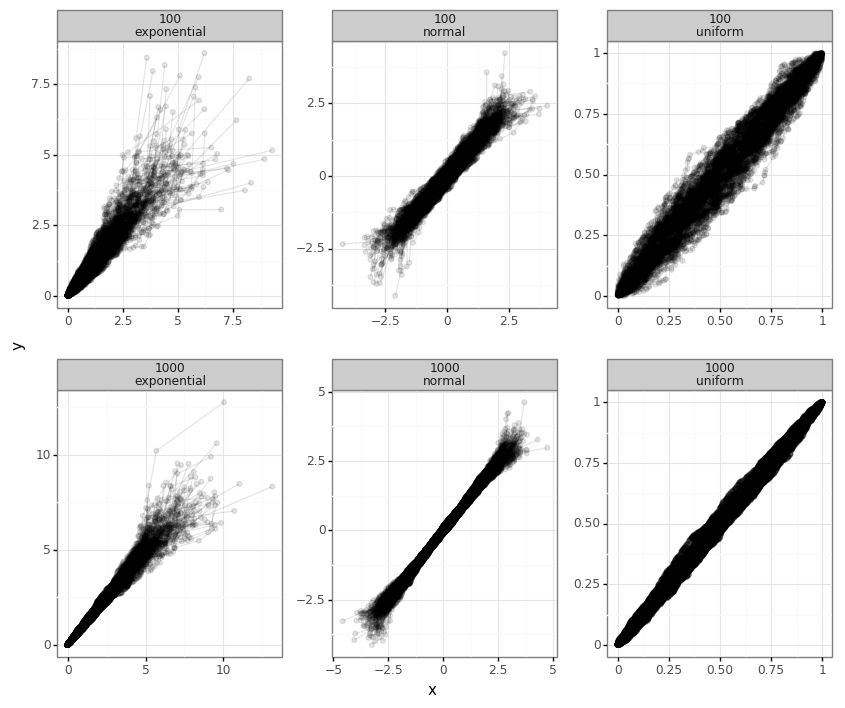

<ggplot: (7556287927)>

In [2]:
N_sims = 100
n_values = [100, 1000]
alpha = 0.05

sims = []
for n in n_values:
    for i in range(N_sims):
        uniform = DataFrame({'x': np.sort(rnd.uniform(size = n)), 'y': np.sort(rnd.uniform(size = n)), 'distribution': 'uniform', 'n': n}) \
            .assign(run = i, xlim = 0, ylim = 1, gg_xlim = 1) # These are for the envelopes
        normal = DataFrame({'x': np.sort(rnd.normal(size = n)), 'y': np.sort(rnd.normal(size = n)), 'distribution': 'normal', 'n': n, 'run': i}) \
            .assign(run = i, xlim = -6, ylim = 6, gg_xlim = 2.5)
        exponential = DataFrame({'x': np.sort(rnd.exponential(size = n)), 'y': np.sort(rnd.exponential(size = n)), 'distribution': 'exponential', 'n': n, 'run': i}) \
            .assign(run = i, xlim = 0, ylim = 12, gg_xlim = 4.5)
        
        sims.append(pd.concat([uniform, normal, exponential], ignore_index = True))
        
qq_points = pd.concat(sims, ignore_index = True)
ggplot(qq_points, aes(x = 'x', y = 'y')) + \
    geom_point(alpha = 0.1) + \
    geom_line(aes(group = 'run'), alpha = 0.1) + \
    facet_wrap(['n', 'distribution'], scales = 'free') + \
    coord_fixed(ratio = 1) + \
    theme_bw() + \
    theme(figure_size = (10, 8),
          panel_spacing = 0.5)

**The fluctuation patterns are indeed different. The variability of the qq-lines in the uniform distribution is the same over the support but the normal and exponential distributions have more variability in the tails.**

**Below, we also built the envelopes for the qq-points above. For that, we created a slightly more general function to interpolate points over the support of different distributions. Moreover, to better visualize the envelopes, we cut a little bit off from the tails of the normal and exponential distributions.**

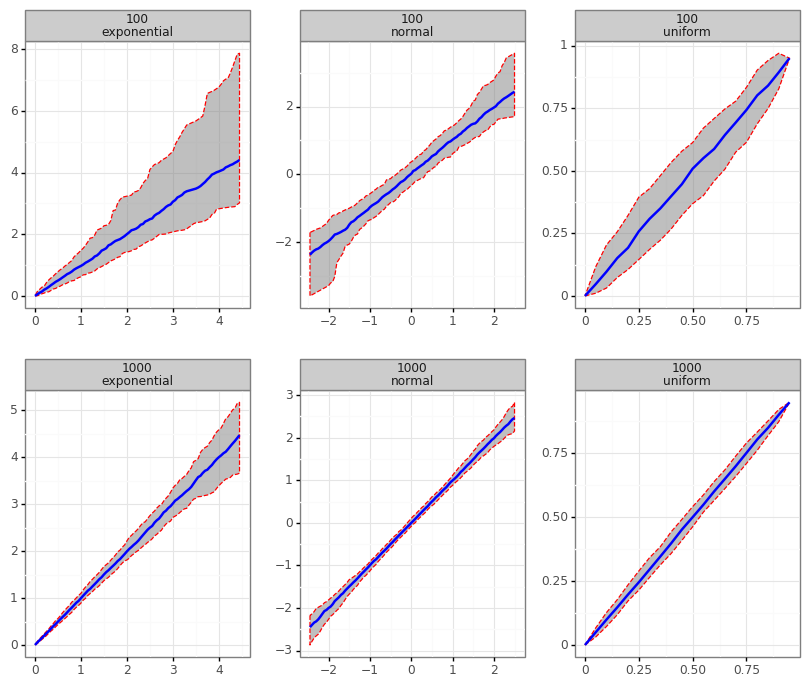

<ggplot: (7561624980)>

In [3]:
def tabulate_qq_general(run: DataFrame, xlim: int, ylim: int, gg_xlim: float) -> DataFrame:
    """Uses linear interpolation to tabulate values of qq-line on a grid"""
    xi = np.arange(xlim, ylim, 0.05)
    df = run[['x', 'y']].copy()
    
    # Fix endpoints for complete interpolation
    if df.iloc[0, 0] != 0:
        df = df.append(df.iloc[0]).shift(1)
        df.iloc[0,:] = np.min(xi)
    if df.iloc[-1,0] != 1:
        df = df.append(Series({'x': np.max(xi), 'y': np.max(xi)}), ignore_index=True)
    
    # Define interpolator and evalute it on the grid
    qq_interpolated = DataFrame({'x': xi, 'y': interp1d(df['x'], df['y'])(xi)}) \
        .query('abs(x) < {}'.format(gg_xlim))
    
    return qq_interpolated


qq_envelopes = qq_points.groupby(['distribution', 'n', 'run']) \
    .apply(lambda df: tabulate_qq_general(df, xlim = df['xlim'].min(), ylim = df['ylim'].max(), gg_xlim = df['gg_xlim'].min())) \
    .reset_index(level = [0, 1, 2]) \
    .groupby(['distribution', 'n', 'x'])['y'] \
    .aggregate('quantile', [alpha/2, 0.5, 1 - alpha/2]) \
    .unstack() \
    .rename(columns = {alpha/2: 'q1', 0.5: 'q2', 1 - alpha/2: 'q3'}) \
    .reset_index()

ggplot(qq_envelopes) + \
    geom_ribbon(aes(x = 'x', ymin = 'q1', ymax = 'q3'), fill = 'gray', alpha = 0.5, color = 'red', linetype = '--') + \
    geom_line(aes(x = 'x', y = 'q2'), color = 'blue', size = 1) + \
    scale_x_continuous(name = '') + \
    scale_y_continuous(name = '') + \
    facet_wrap(['n', 'distribution'], scales = 'free') + \
    theme_bw() + \
    coord_fixed(ratio = 1) + \
    theme(figure_size = (10, 8),
          panel_spacing = 0.5)

**The median nicely follows the diagonal in every case but the $95\%$ confidence bands are a bit rough.**

## 3.2 Confidence envelopes through simulations (<font color='red'>1p</font>)

If the distribution to compare with is known, then the use of theoretical quantiles reduces the amount of noise in the graph. For instance, if we want to compare a sample vector $y$ of size $100$ with uniform distribution, we can set 
~~~~
x = scipy.stats.uniform().ppf(np.arrange(0, 1.0001, 0.01))
~~~~
to set theoretical quantiles on the $x$-axis. This gives a sightly simpler way to compute confidence envelope:

*  Draw $1000$ sample vectors $y$ of size 100 for all distributions.
*  Compute desired empirical quantiles with `numpy.quantile` or `sort` 
~~~~~
q = np.arange(0, 1.001, 0.01)
Q.iloc[i,:] = np.quantile(y, q = q)
~~~~~
   and store results into a row of a $1000\times 100$ matrix `Q`. 
 
* As a result, every column `Q.iloc[:,j]` represents individual measurements of a quantile `q[j]` and you can compute compute 2.5%, 50% and 97.5% empirical quantiles for each `q[j]`. 
  With these you values you can draw the confidence envelope. 
  Draw these confidence envelopes on a separate plot for all three distributions.

Alternatively, you can construct the confidence envelope similarly to the way we constructed the the envelope above with the exeption that there is no need to use interpolation -- all $\mathrm{qq}(\xi_j)$ values will correspond to some $y_i$. 


## Solution

**Instead of plotting generated values against generated values as in the figure above, we should use the fact that we know how to find the theoretical quantiles of our distributions. Below, we created the confidence bands for the qq-plots by using the theoretical quantiles on the x-axis and generated quantiles on the y-axis.**

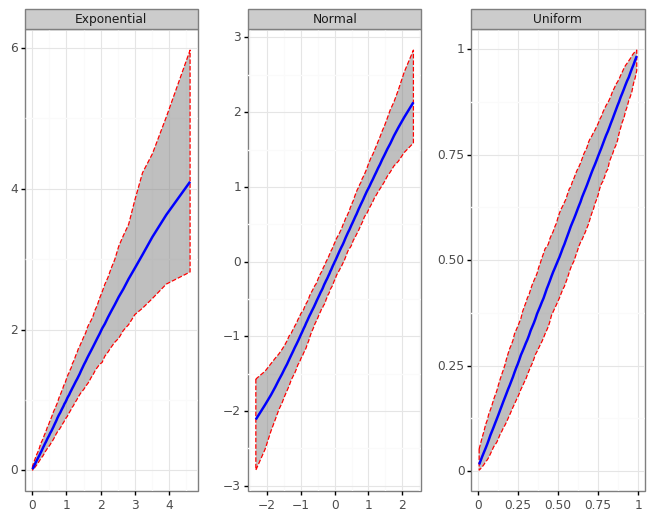

<ggplot: (7562145863)>

In [4]:
def envelope(func_random: callable, func_ppf: callable, distribution: str, alpha = 0.05) -> DataFrame:
    x_grid = np.arange(0, 1.001, 0.01)
    x_grid[0] += 10**(-2)
    x_grid[-1] -= 10**(-2)
    
    random_mat = func_random(size = (1000, 100))
    Q = np.apply_along_axis(np.quantile, 1, random_mat, q = x_grid)
    
    quantile_mat = np.apply_along_axis(np.quantile, 0, Q, q = [alpha/2, 0.5, 1 - alpha/2])
    dat = DataFrame(quantile_mat.T, columns = ['q1', 'q2', 'q3']) \
        .assign(x = func_ppf(x_grid), distribution = distribution)
    
    return dat
    

envelope_uniform = envelope(np.random.uniform, stats.uniform.ppf, "Uniform")
envelope_normal = envelope(np.random.normal, stats.norm.ppf, "Normal")
envelope_exponential = envelope(np.random.exponential, stats.expon.ppf, "Exponential")

envelope_dat = pd.concat([envelope_uniform, envelope_normal, envelope_exponential], ignore_index = True)

gg = ggplot(envelope_dat) + \
    geom_ribbon(aes(x = 'x', ymin = 'q1', ymax = 'q3'), fill = 'gray', alpha = 0.5, color = 'red', linetype = '--') + \
    geom_line(aes(x = 'x', y = 'q2'), color = 'blue', size = 1) + \
    scale_x_continuous(name = '') + \
    scale_y_continuous(name = '') + \
    facet_wrap('distribution', scales = 'free') + \
    theme_bw() + \
    coord_fixed(ratio = 1) + \
    theme(figure_size = (8, 6),
          panel_spacing = 0.5)
display(gg)

**The result is pretty much the same as above but much smoother.**

## 3.3 Theoretical confidence envelopes for uniform distribution (<font color='red'>1p</font>)

In general, finding analytical confidence intervals for the qq-plot is intractable unless you compare a sample against known distribution with simple enough cumulative distribution function.
In particular, there is a closed form solution for uniform distribution over $[0,1]$.
Let $\boldsymbol{y}$ be an $n$ elelment i.i.d. sample from uniform distribution, i.e., all components are independent and uniformly distributed.
Then $\boldsymbol{z}\gets \mathrm{sort}(\boldsymbol{y})$ then $z_k$ is distributed according to beta distribution with parameters $k$ and $n+1-k$. Hence, for uniform distribution we can provide analytical confidence intervals by solving the equations:

\begin{align*}
     & \Pr[z_k\gets\mathcal{B}(k, n+1-k): z_k\leq \alpha]= 2.5\% \\
     & \Pr[z_k\gets\mathcal{B}(k, n+1-k): z_k\leq \beta]= 97.5\%\enspace.
\end{align*}

for $\alpha$ and $\beta$. For that you can use function `scipy.stats.beta.ppf` with appropriate parameters. Draw the corresponding graph and compare with empirical results you obtained in the previous exercise. 
How many points of qq-plot should lie outside confidence intervals if $\boldsymbol{y}$ is  uniform distribution?
Veryfy your quess with few samples drawn on top of the confidence envelope.


## Solution

**For the uniform distribution, we found the theoretical quantiles for each position $k, k = 1, ..., n$ using the beta distribution, drawing the confidence evelope below. Moreover, we took $n = 100$ and generated $n$ uniformly distributed random variables in $n$ different runs, sorting them within each run. We plotted points from one of the runs in black and then 20 points randomly from the sorted sequences in red.**

Average rate of mistakes (points outside the envelope): 5.37%


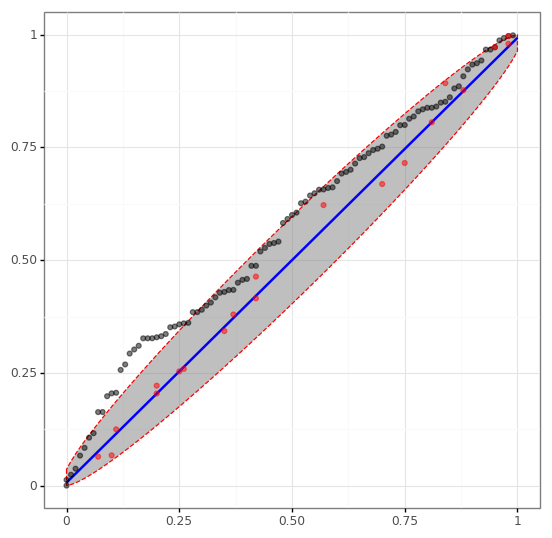

<ggplot: (7546310341)>

In [11]:
n = 100

quantiles = [stats.beta(k, n + 1 - k).ppf(q = [0.025, 0.5, 0.975]) for k in range(1, n + 1)]
qq_beta = DataFrame(np.array(quantiles), columns = ['q1', 'q2', 'q3']) \
    .assign(x = np.linspace(0, 1, n))

x = np.tile(np.linspace(0, n - 1, n), n)
y = np.sort(np.random.uniform(size = (n, n))).flatten()
qq_points = DataFrame({'x': x / 100, 'y': y})
print('Average rate of mistakes (points outside the envelope): {}%'.format(np.mean((y < qq_beta.loc[x, 'q1']) | (y > qq_beta.loc[x, 'q3']))*100))

gg = ggplot() + \
    geom_ribbon(qq_beta, aes(x = 'x', ymin = 'q1', ymax = 'q3'), fill = 'gray', alpha = 0.5, color = 'red', linetype = '--') + \
    geom_line(qq_beta, aes(x = 'x', y = 'q2'), color = 'blue', size = 1) + \
    geom_point(qq_points.loc[:n], aes(x = 'x', y = 'y'), alpha = 0.5) + \
    geom_point(qq_points.sample(20), aes(x = 'x', y = 'y'), colour = 'red', alpha = 0.5) + \
    scale_x_continuous(name = '') + \
    scale_y_continuous(name = '') + \
    theme_bw() + \
    coord_fixed(ratio = 1)
display(gg)

**There can be many points that go outside the envelope in one run but from many runs we could expect roughly 5% of the points to be out in average. This is visualised by the red points and by the empirical average rate of mistakes that we computed over all our runs.**